In [2]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [9]:
import numpy as np
from datetime import datetime

class RFAData:
    def __init__(self, filename):
        """Initialize RFA data from a measurement file."""
        # Header information
        self.measurement_time = None
        self.operator = ""
        self.comments = ""
        self.projectile = ""
        
        # Beam parameters
        self.energy = 0.0
        self.extractor = 0.0
        self.focus1 = 0.0
        self.focus2 = 0.0
        
        # RFA parameters
        self.suppressor_voltage = 0.0
        self.rfa_comments = ""
        
        # Wien filter
        self.wien_voltage = 0.0
        
        # Sweep parameters
        self.sweep_start = 0.0
        self.sweep_end = 0.0
        self.sweep_step = 0.0
        self.measurement_time = 0.0
        self.integration_time = 0.0
        self.plc = 0.0
        self.points_per_step = 0.0
        
        # Measurement data
        self.retarding_voltage = None  # Will be numpy array
        self.mean_current = None       # Will be numpy array
        
        self._load_file(filename)
    
    def _load_file(self, filename):
        """Load and parse the measurement file."""
        with open(filename, 'r') as file:
            lines = file.readlines()
            
        # Parse header information
        data_start_index = None
        for i, line in enumerate(lines):
            line = line.strip()
            
            if not line:
                continue
            
            # Check for data section
            if "Retading voltage (kV)" in line and "Mean current FC (A)" in line:
                data_start_index = i + 1
                break
                
            # Handle fields that might be empty
            if ":" in line:
                parts = line.split(':', 1)  # Split on first colon only
                field = parts[0].strip()
                value = parts[1].strip() if len(parts) > 1 else ""
                
                # Remove any remaining tabs
                value = value.replace('\t', '').strip()
                
                if field == "Measured on":
                    datetime_str = value
                    self.measurement_time = datetime.strptime(datetime_str, "%H:%M:%S %d/%m/%Y")
                elif field == "Operated by":
                    self.operator = value
                elif field == "Comments":
                    self.comments = value
                elif field == "Projectile":
                    self.projectile = value
                elif field == "Energy (V)":
                    self.energy = float(value) if value else 0.0
                elif field == "Extractor (%)":
                    self.extractor = float(value) if value else 0.0
                elif field == "Focus 1 (%)":
                    self.focus1 = float(value) if value else 0.0
                elif field == "Focus 2 (%)":
                    self.focus2 = float(value) if value else 0.0
                elif field == "Suppressor voltage (V)":
                    self.suppressor_voltage = float(value) if value else 0.0
                elif field == "Wien voltage (V)":
                    self.wien_voltage = float(value) if value else 0.0
                elif field == "Sweep start (kV)":
                    self.sweep_start = float(value) if value else 0.0
                elif field == "Sweep end (kV)":
                    self.sweep_end = float(value) if value else 0.0
                elif field == "Sweep step (V)":
                    self.sweep_step = float(value) if value else 0.0
                elif field == "Measurement time (s)":
                    self.measurement_time = float(value) if value else 0.0
                elif field == "Integration time (s)":
                    self.integration_time = float(value) if value else 0.0
                elif field == "PLC":
                    self.plc = float(value) if value else 0.0
                elif field == "Points per step":
                    self.points_per_step = float(value) if value else 0.0
        
        if data_start_index is None:
            raise ValueError("Could not find data section in file")
            
        # Parse measurement data
        data_lines = [line.strip() for line in lines[data_start_index:] if line.strip()]
        voltage_data = []
        current_data = []
        
        for line in data_lines:
            v, i = line.split('\t')
            voltage_data.append(float(v.replace('E', 'e')))
            current_data.append(float(i.replace('E', 'e')))
        
        self.retarding_voltage = np.array(voltage_data)
        self.mean_current = np.array(current_data)

Measurement taken by: Ennio Kristof
Energy: 2000.0 V
Number of data points: 221


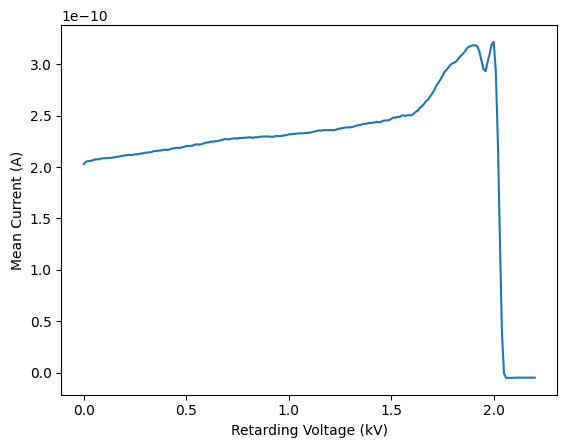

In [10]:
# Load a measurement file
rfa_data = RFAData(r"H:\My Drive\Lab4 - RFA\data & processing\raw data\2024-11-27\rfa full 5 - sup0 - 2k.txt")

# Access the data
print(f"Measurement taken by: {rfa_data.operator}")
print(f"Energy: {rfa_data.energy} V")
print(f"Number of data points: {len(rfa_data.retarding_voltage)}")

# Plot the data
import matplotlib.pyplot as plt
plt.plot(rfa_data.retarding_voltage, rfa_data.mean_current)
plt.xlabel('Retarding Voltage (kV)')
plt.ylabel('Mean Current (A)')
plt.show()